In [11]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [12]:
inputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "inputs")
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "outputs")

# load fred description and data
des_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_description.csv'), sep=";")

fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_transf.csv'))
fred_df["date"] = pd.to_datetime(fred_df["date"])
fred_df.set_index("date", inplace=True)

raw_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_raw.csv'))
raw_fred_df["date"] = pd.to_datetime(raw_fred_df["date"])
raw_fred_df.set_index("date", inplace=True)

In [13]:
# chek for missing values
fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI             1960-01-01
T5YFFM          1960-01-01
T1YFFM          1960-01-01
TB6SMFFM        1960-01-01
TB3SMFFM        1960-01-01
                   ...    
VIXCLSx         1962-07-01
ANDENOx         1968-03-01
TWEXAFEGSMTHx   1973-02-01
UMCSENTx        1978-02-01
ACOGNO          1992-03-01
Length: 127, dtype: datetime64[ns]

In [14]:
delete_groups = ["Interest and Exchange Rates", "Stock Market"]
delete_series = ["ACOGNO", "UMCSENTx", "TWEXAFEGSMTHx"]

# delete groups
macro_fred = []
for colname in fred_df.columns:

    if colname not in des_fred_df["fred"].values:
        continue

    group = des_fred_df[des_fred_df["fred"] == colname]["group"].values[0]

    if (group not in delete_groups) and (colname not in delete_series):
        macro_fred.append(fred_df[colname])
macro_fred_df = pd.concat(macro_fred, axis=1)

In [15]:
# chek for missing values
macro_fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI               1960-01-01
CONSPI            1960-01-01
NONREVSL          1960-01-01
REALLN            1960-01-01
BUSLOANS          1960-01-01
                     ...    
UEMP15OV          1960-01-01
UEMP5TO14         1960-01-01
MANEMP            1960-01-01
DSERRG3M086SBEA   1960-01-01
ANDENOx           1968-03-01
Length: 96, dtype: datetime64[ns]

### 1) Daily Macro Features

In [16]:
# parameters
k = 4

# select data
X = macro_fred_df.dropna()

# compute cosine distance = 1 - cosine similarity
X_similarity = cosine_distances(X)

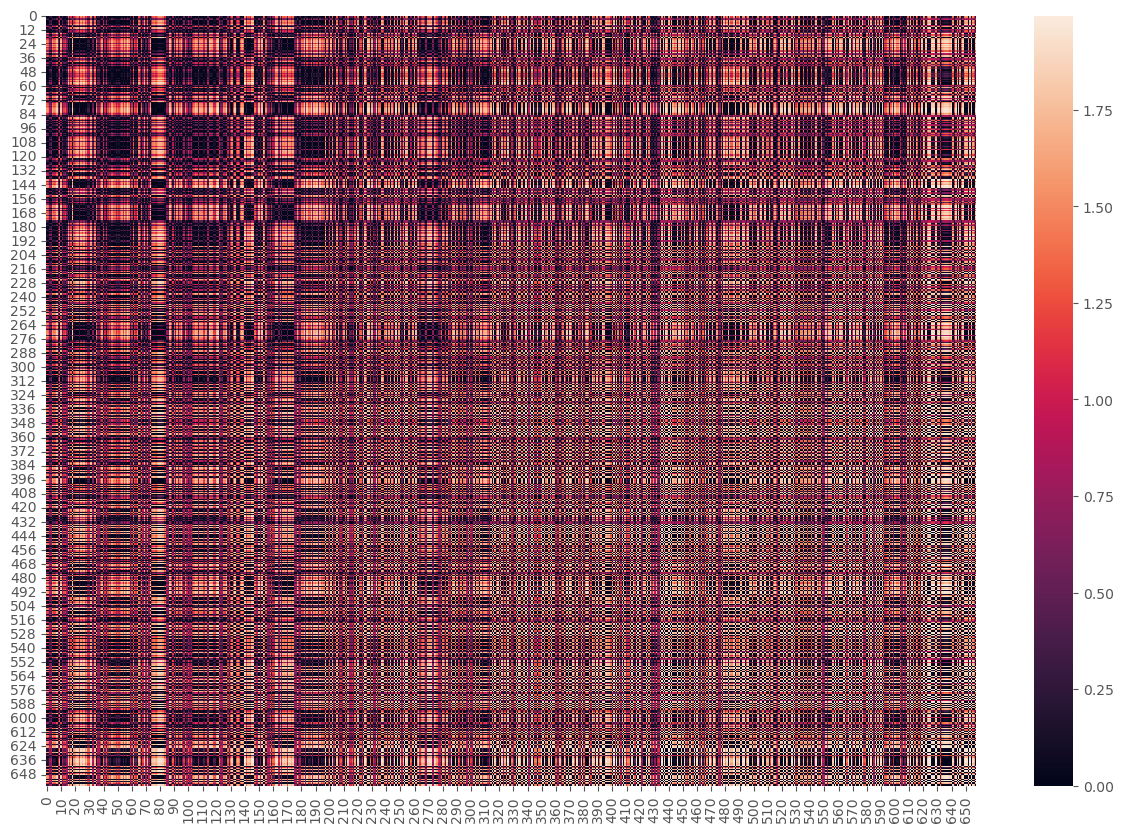

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_similarity)

# save heatmap figure
plt.savefig(os.path.join(outputs_path, "results", "cosine_similarity.png"))

In [18]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


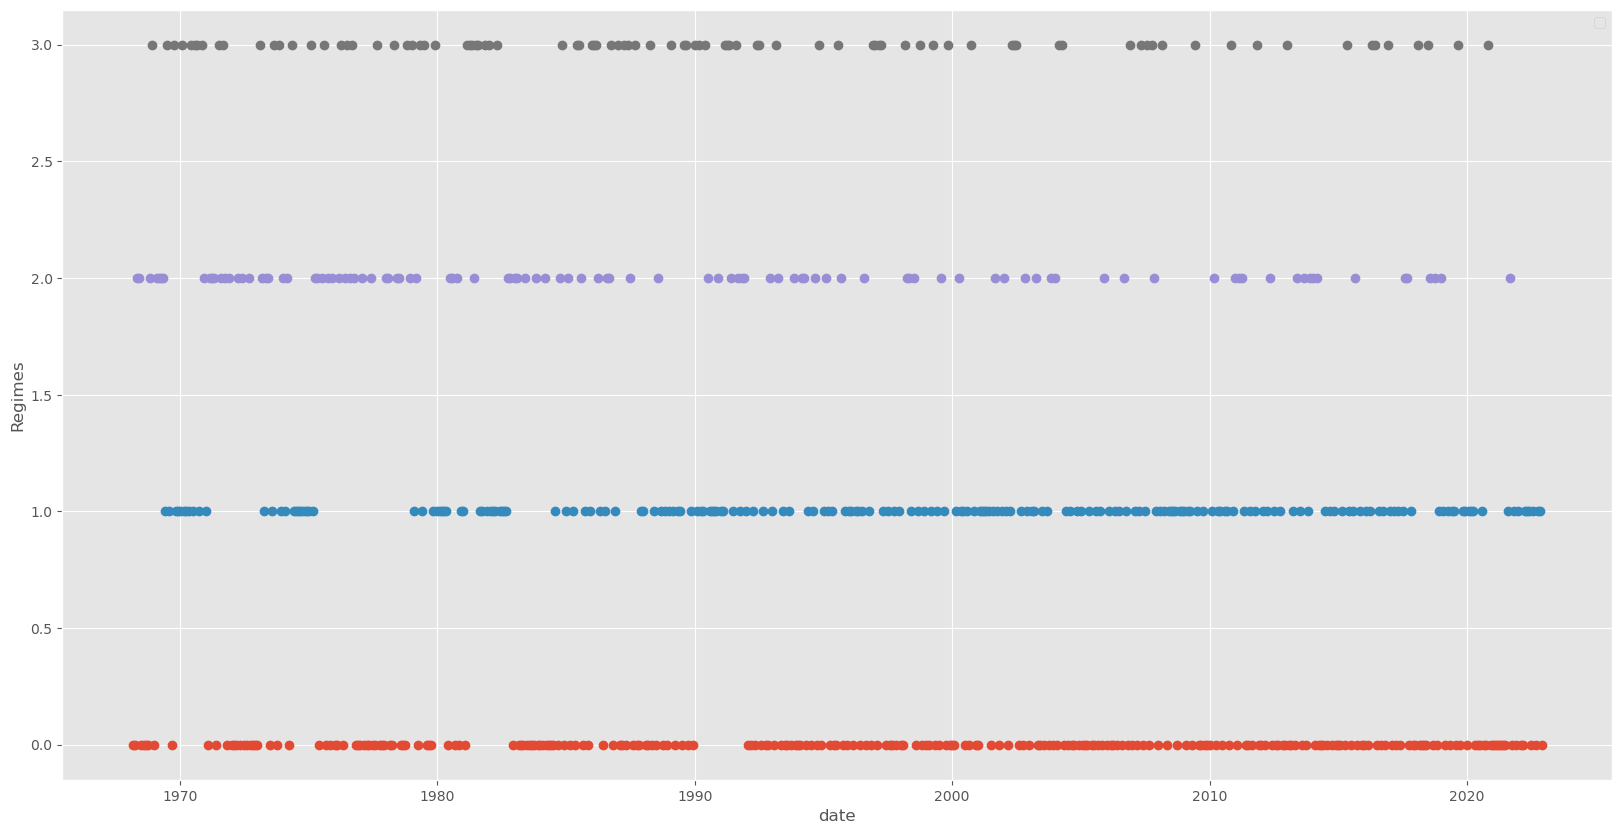

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [20]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

S&P 500
variable          
0         0.917724
1         0.198661
2         0.844157
3         0.603637

### 2) Rolling Windows of the Macro Features

In [21]:
# parameters
k = 3
window = 12

# select data
X = macro_fred_df.rolling(window=window).mean().dropna()

# compute similarity
import sklearn.metrics.pairwise as sk
# X_similarity = cosine_distances(X)
X_similarity = sk.euclidean_distances(X)

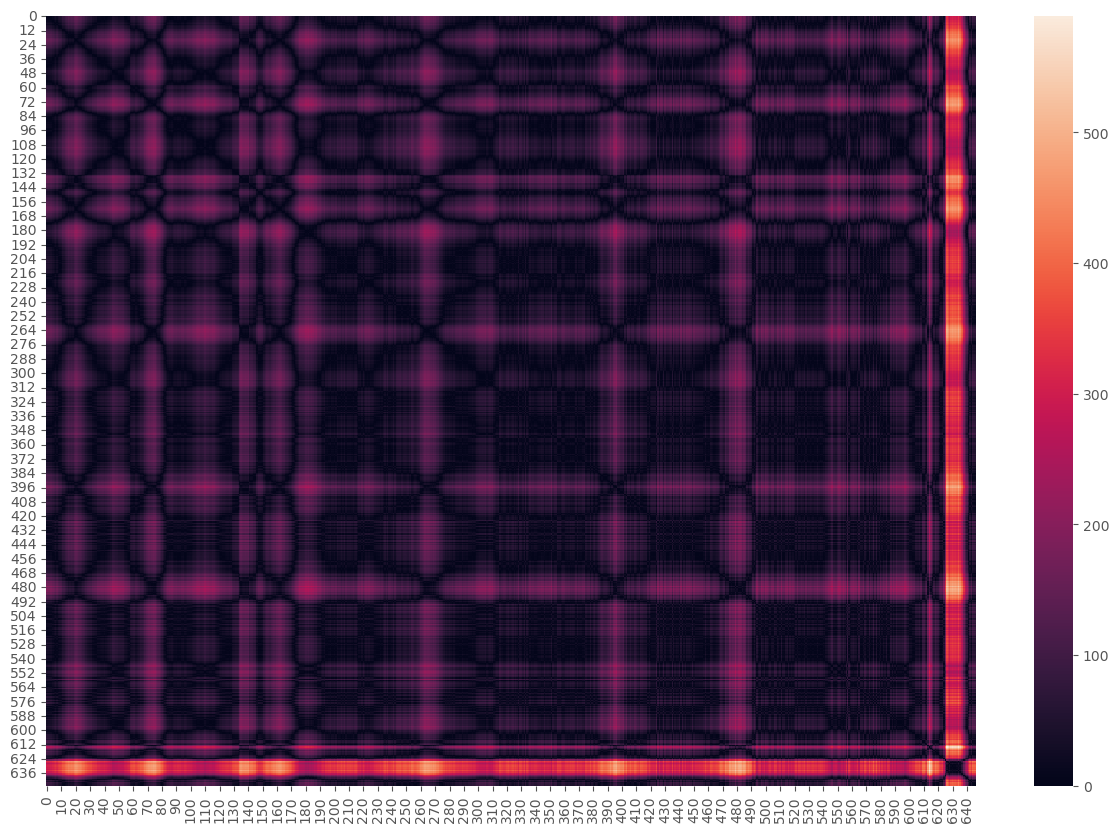

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_similarity)

# save heatmap figure
plt.savefig(os.path.join(inputs_path, "heatmap_euclidean.png"))

In [65]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


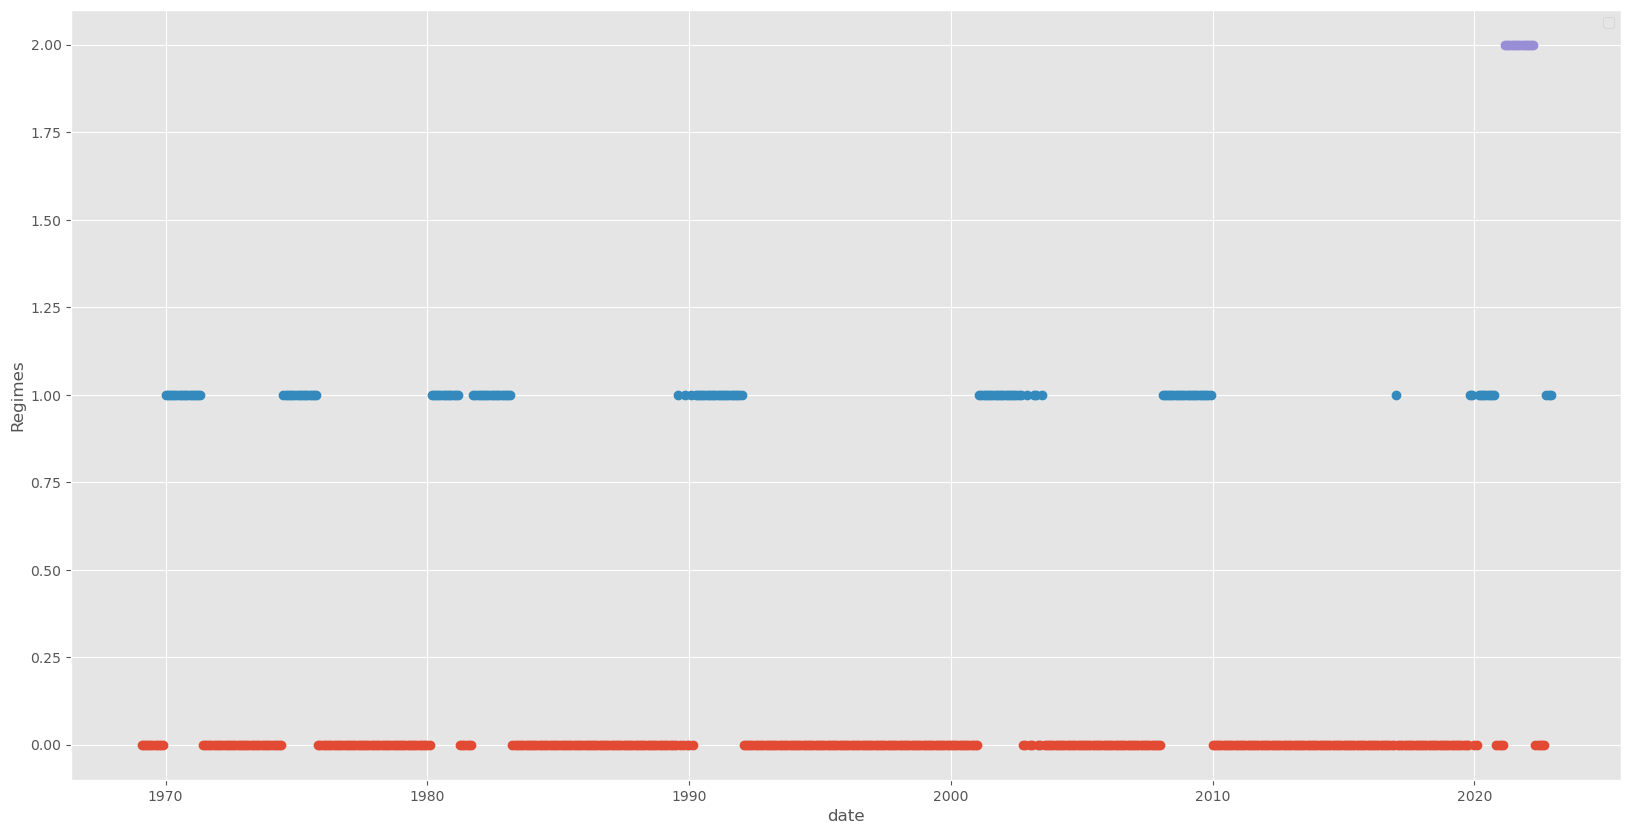

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [75]:
lengths = []
for i in range(3):
    hard_days = X.loc[:, "cluster"] == i
    hard_days = hard_days[hard_days == True]
    lengths.append(len(hard_days))

hard_days = X[X.loc[:, "cluster"] == 0]

483


In [76]:
# parameters
k = 3
window = 12

# compute similarity
import sklearn.metrics.pairwise as sk
# X_similarity = cosine_distances(X)
hard_similarity = sk.euclidean_distances(hard_days)

<Axes: >

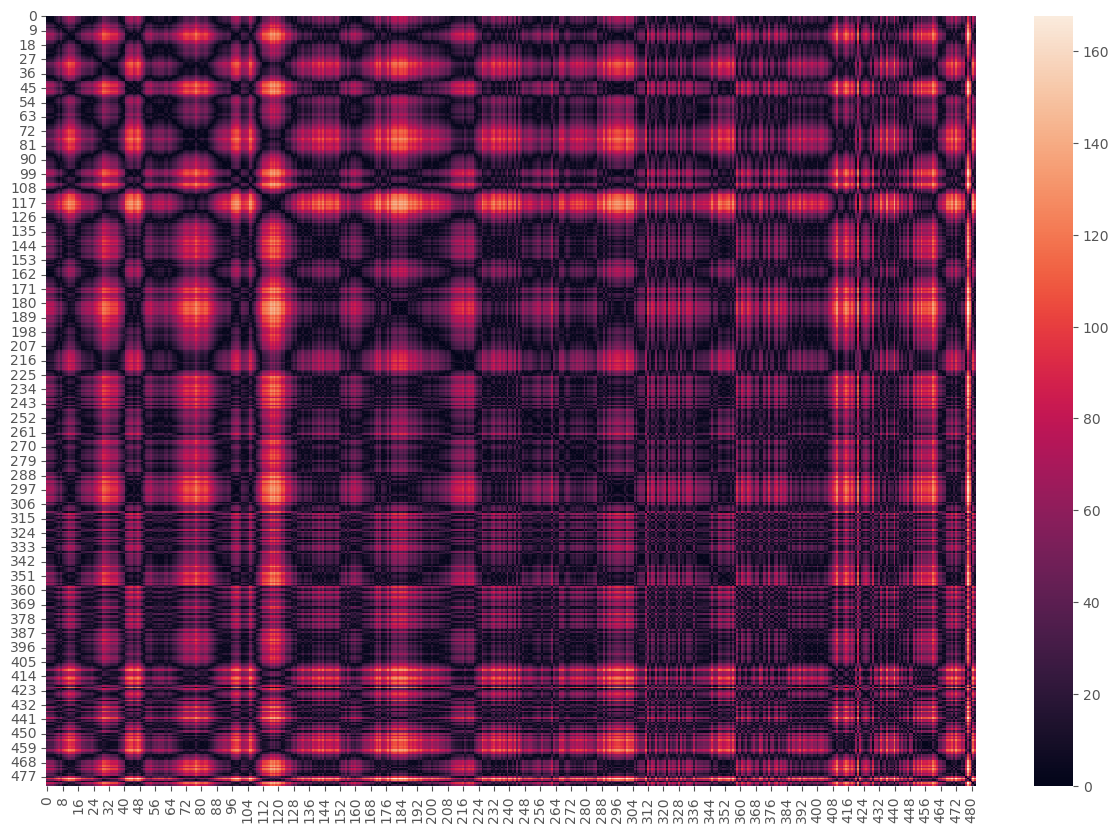

In [78]:
plt.figure(figsize=(15, 10))
sns.heatmap(hard_similarity)

In [79]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=0).fit(hard_similarity)
hard_days.loc[:, "cluster"] = kmeans.labels_

melt_X = hard_days[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


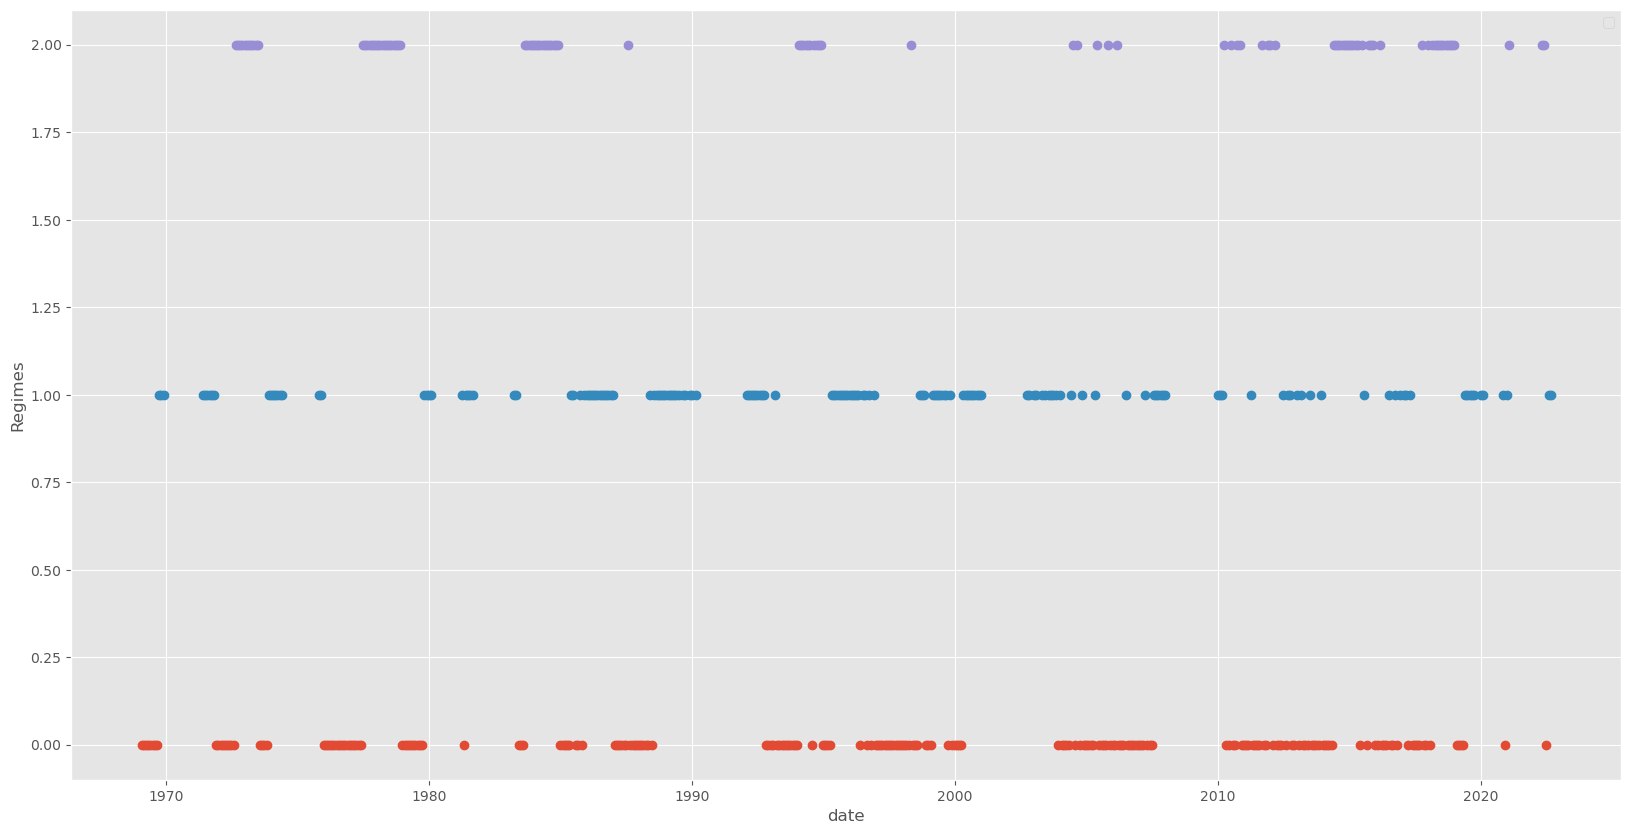

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [15]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

S&P 500
variable          
0         0.337079
1         1.265989
2         0.433759
3         0.145746

### 3) EW Windows of the Macro Features

In [16]:
# parameters
k = 5
halflife = 6

# select data
X = macro_fred_df.ewm(halflife=halflife).mean().dropna()

# compute similarity
X_similarity = cosine_distances(X)

<Axes: >

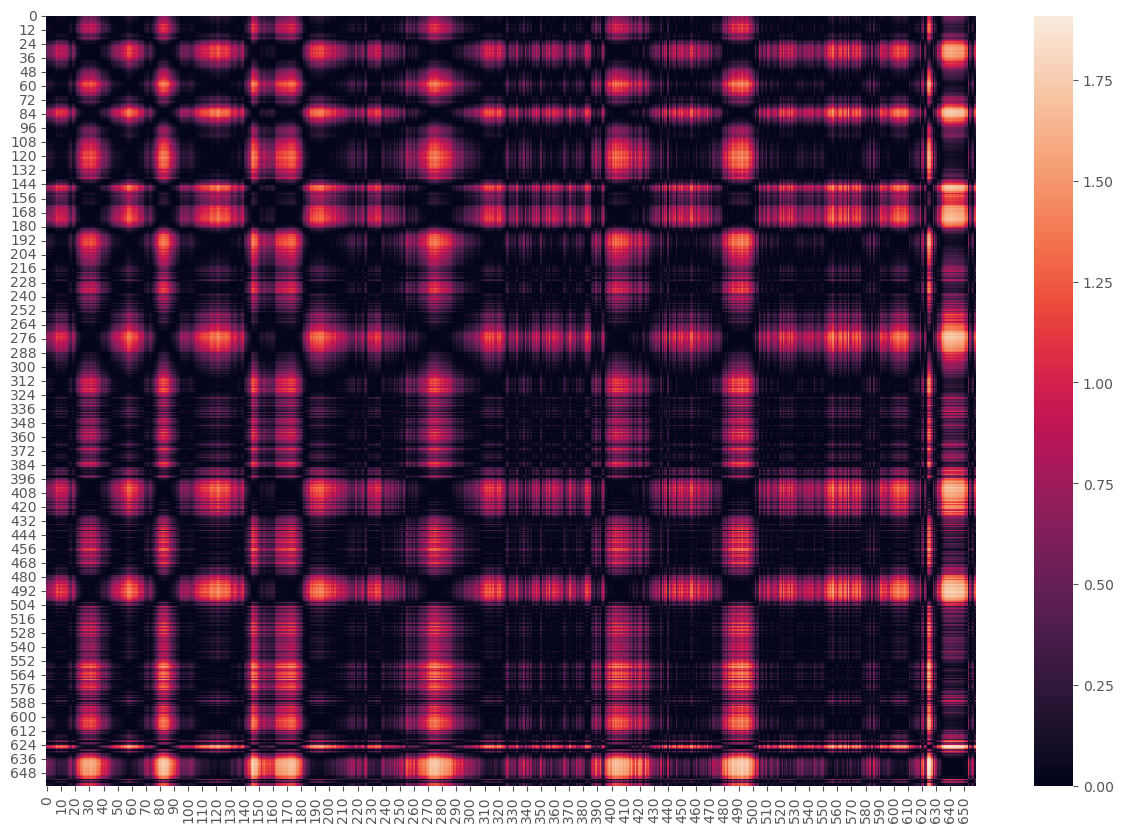

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_similarity)

In [18]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


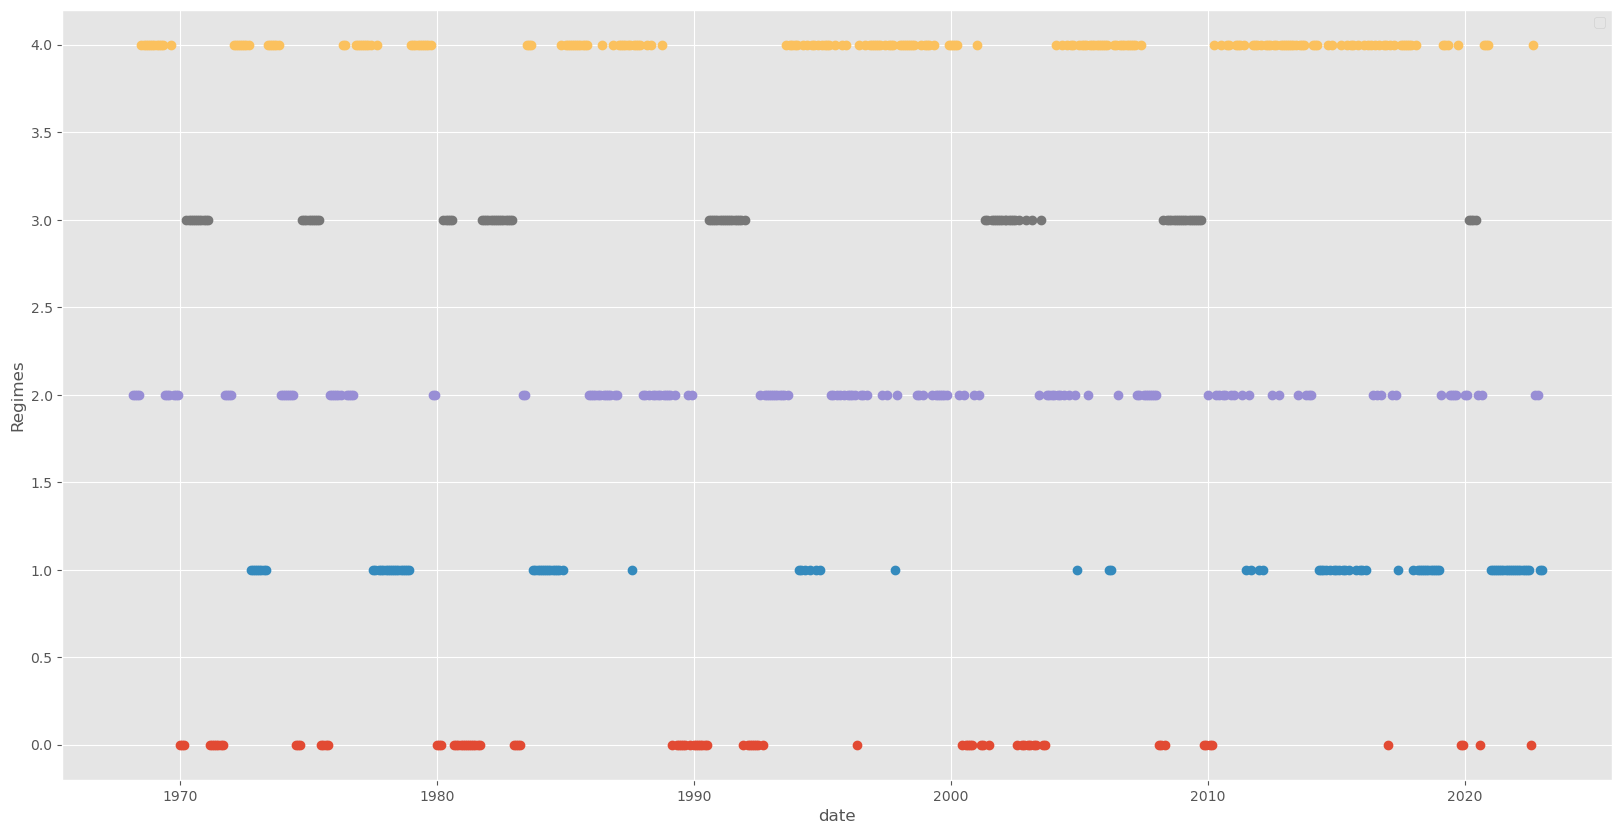

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [20]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
cpi_regimes_df = pd.concat([regimes_df,
                            (raw_fred_df[["CPIAUCSL"]].pct_change(12).dropna() * 100).rename(columns={"CPIAUCSL": "Inflation"}),
                            (raw_fred_df[["RPI"]].pct_change(12).dropna() * 100).rename(columns={"RPI": "Personal Income"}),
                            (raw_fred_df[["FEDFUNDS"]])], axis=1)

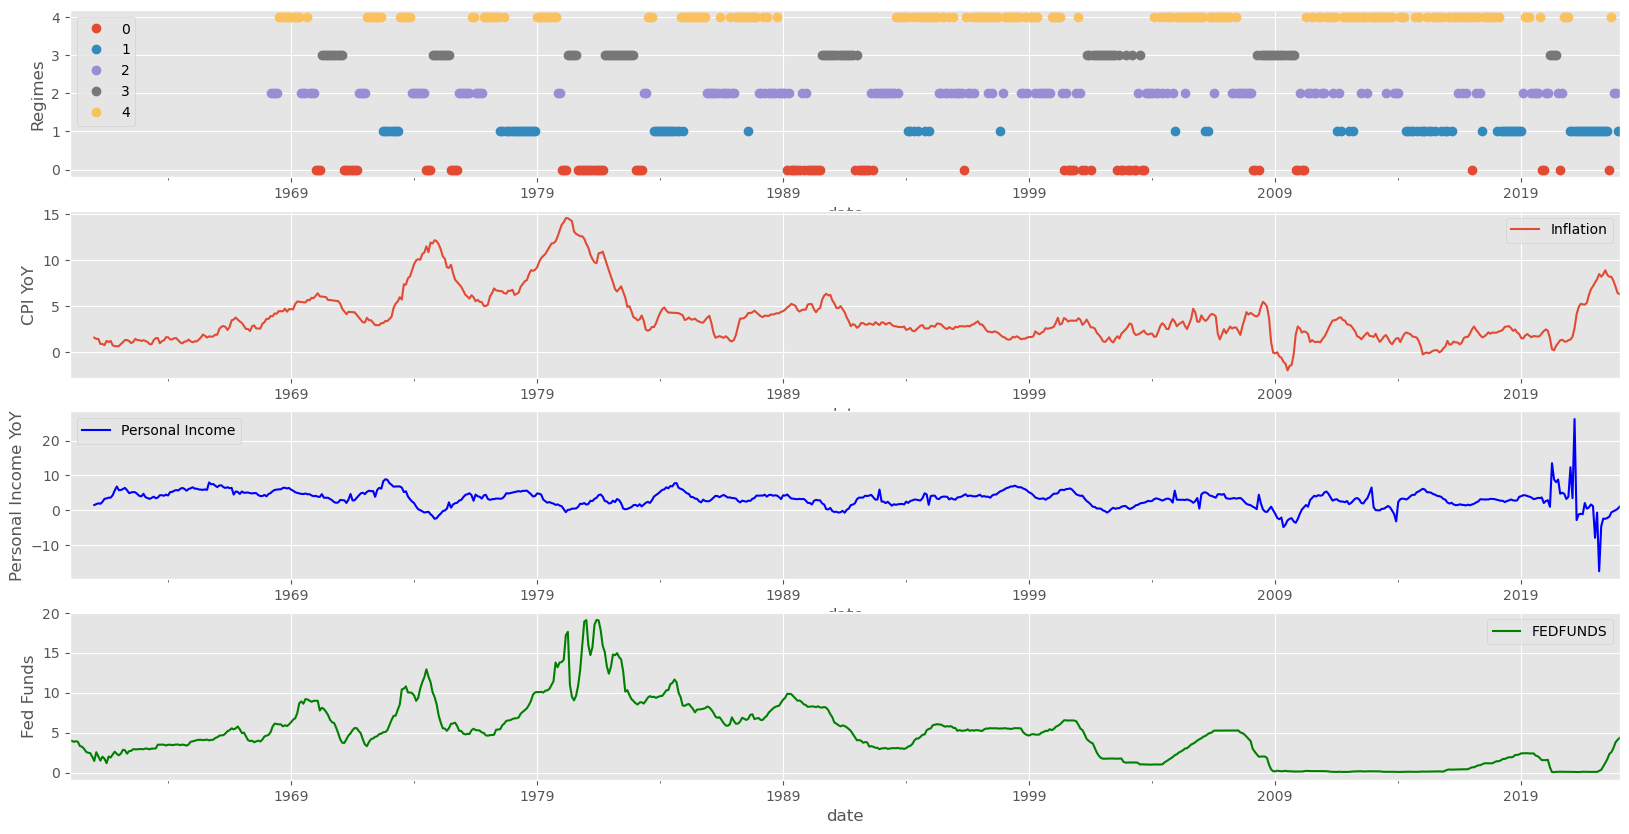

In [21]:
plot_df = cpi_regimes_df.copy()

fig, axs = plt.subplots(4, 1, figsize=(20, 10))

cpi_regimes_df[[v for v in range(k)]].plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Regimes")
axs[0].legend()

cpi_regimes_df[["Inflation"]].plot(ax=axs[1])
axs[1].set_xlabel("date")
axs[1].set_ylabel("CPI YoY")
axs[1].legend()

cpi_regimes_df[["Personal Income"]].plot(ax=axs[2])
# change color
axs[2].lines[0].set_color("blue")
axs[2].set_xlabel("date")
axs[2].set_ylabel("Personal Income YoY")
axs[2].legend()

cpi_regimes_df[["FEDFUNDS"]].plot(ax=axs[3])
# change color
axs[3].lines[0].set_color("green")
axs[3].set_xlabel("date")
axs[3].set_ylabel("Fed Funds")
axs[3].legend()

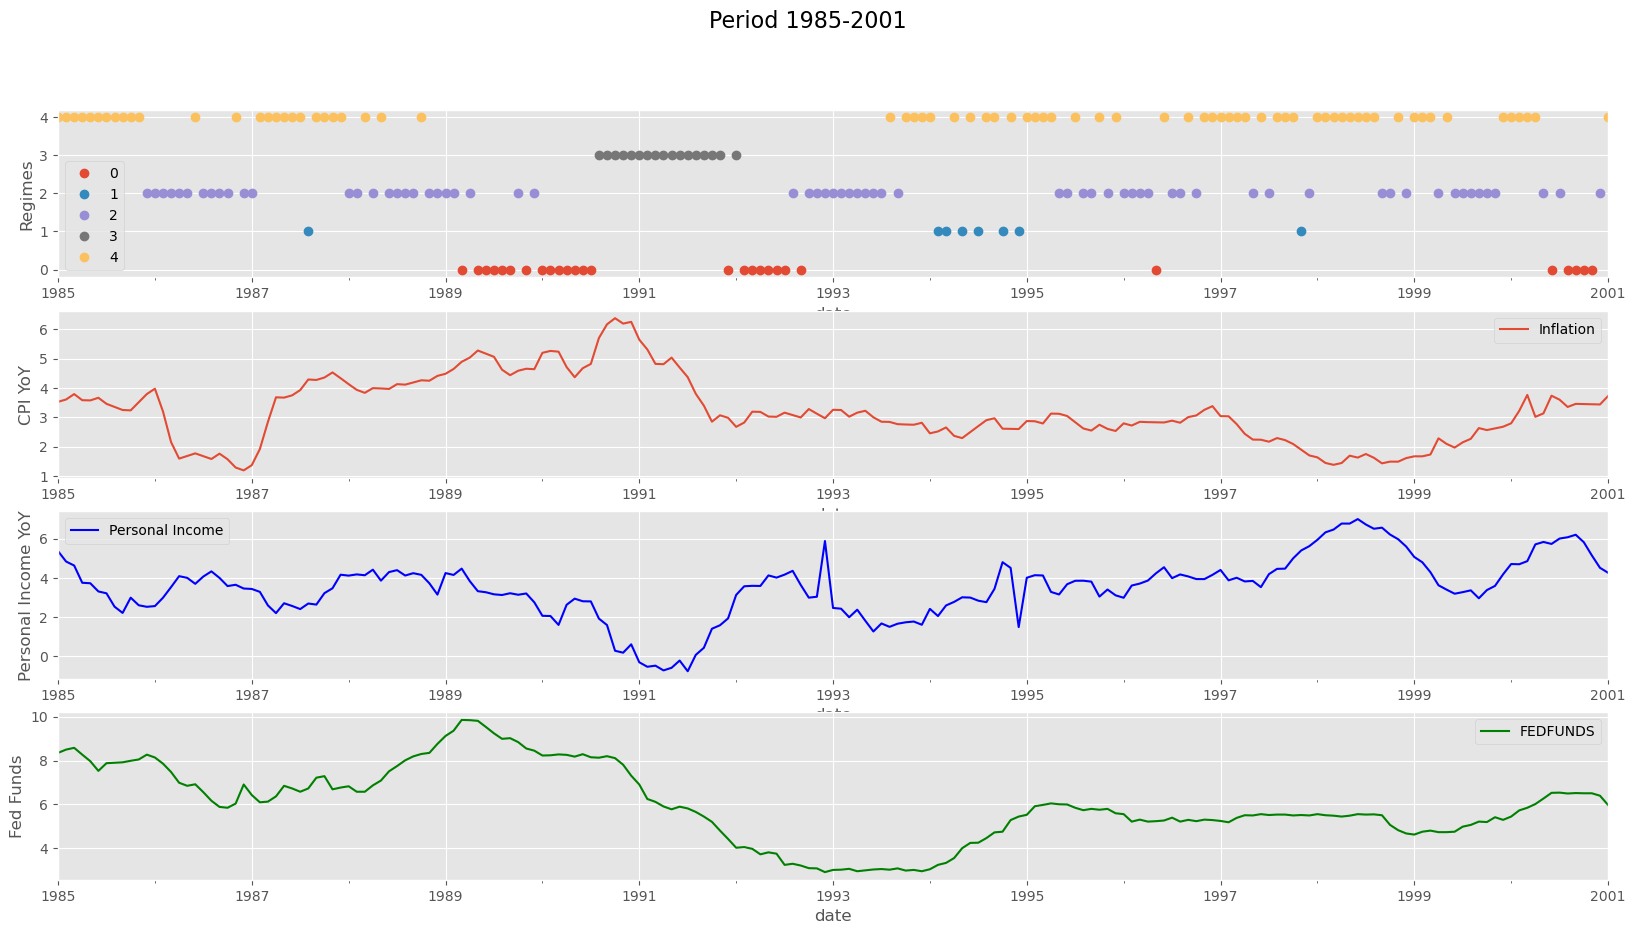

In [22]:
start = "1985-01-01"
end = "2001-01-01"

plot_df = cpi_regimes_df.copy().loc[start:end]

fig, axs = plt.subplots(4, 1, figsize=(20, 10))

fig.suptitle(f'Period {start[0:4]}-{end[0:4]}', fontsize=16)

plot_df[[v for v in range(k)]].plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Regimes")
axs[0].legend()

plot_df[["Inflation"]].plot(ax=axs[1])
axs[1].set_xlabel("date")
axs[1].set_ylabel("CPI YoY")
axs[1].legend()

plot_df[["Personal Income"]].plot(ax=axs[2])
# change color
axs[2].lines[0].set_color("blue")
axs[2].set_xlabel("date")
axs[2].set_ylabel("Personal Income YoY")
axs[2].legend()

plot_df[["FEDFUNDS"]].plot(ax=axs[3])
# change color
axs[3].lines[0].set_color("green")
axs[3].set_xlabel("date")
axs[3].set_ylabel("Fed Funds")
axs[3].legend()

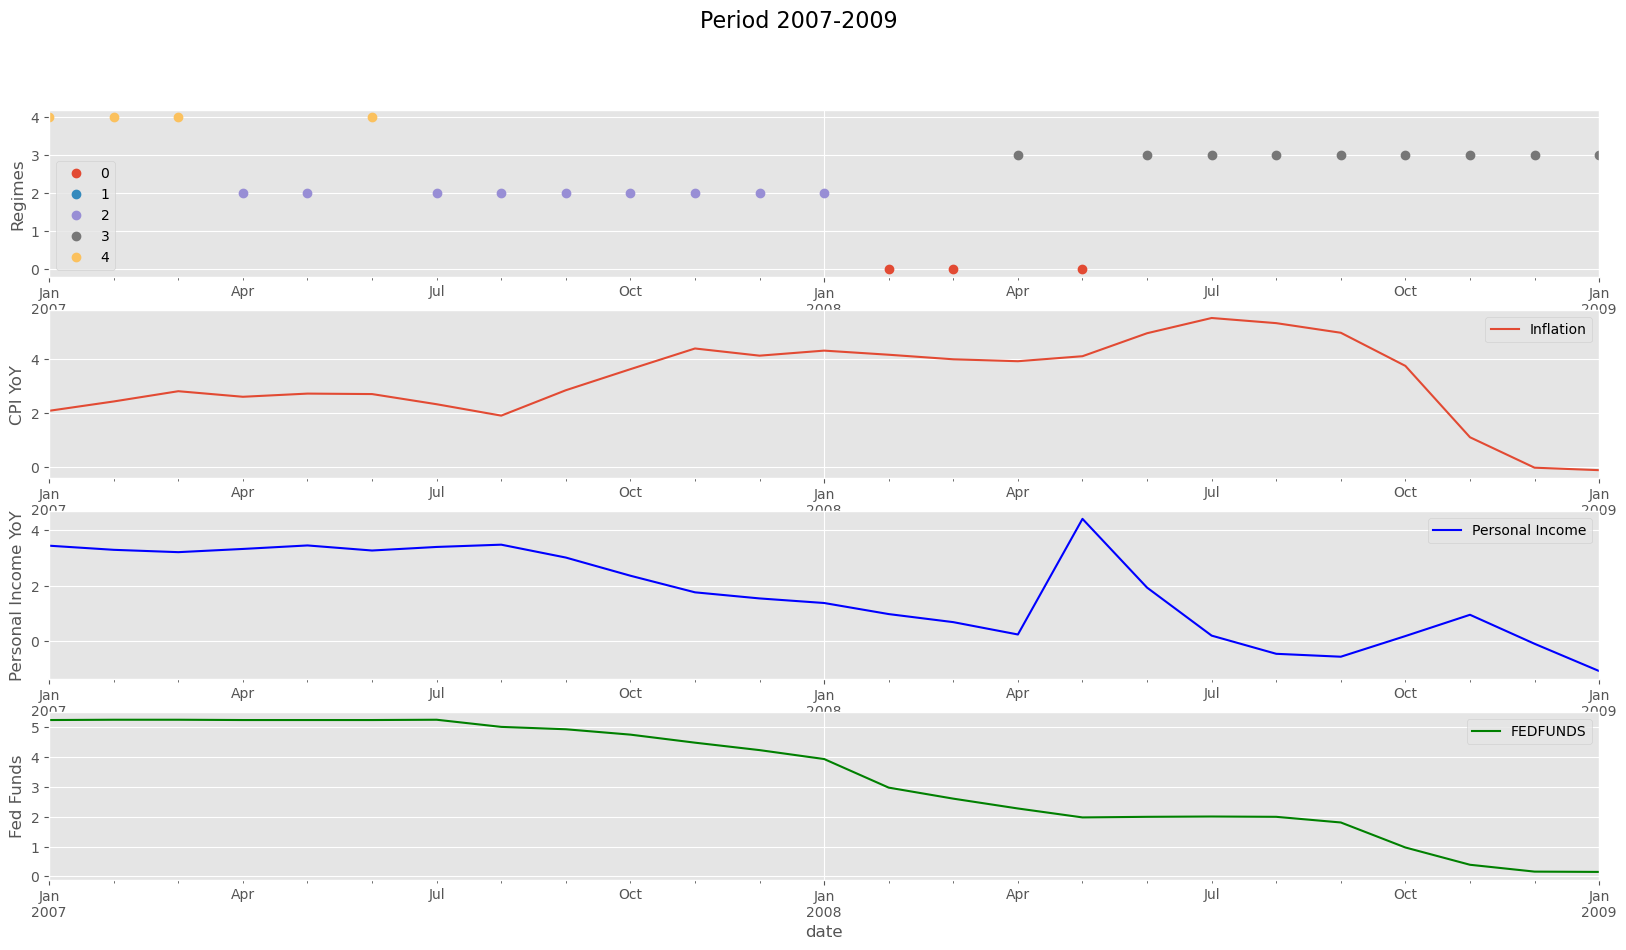

In [23]:
start = "2007-01-01"
end = "2009-01-01"

plot_df = cpi_regimes_df.copy().loc[start:end]

fig, axs = plt.subplots(4, 1, figsize=(20, 10))

fig.suptitle(f'Period {start[0:4]}-{end[0:4]}', fontsize=16)

plot_df[[v for v in range(k)]].plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Regimes")
axs[0].legend()

plot_df[["Inflation"]].plot(ax=axs[1])
axs[1].set_xlabel("date")
axs[1].set_ylabel("CPI YoY")
axs[1].legend()

plot_df[["Personal Income"]].plot(ax=axs[2])
# change color
axs[2].lines[0].set_color("blue")
axs[2].set_xlabel("date")
axs[2].set_ylabel("Personal Income YoY")
axs[2].legend()

plot_df[["FEDFUNDS"]].plot(ax=axs[3])
# change color
axs[3].lines[0].set_color("green")
axs[3].set_xlabel("date")
axs[3].set_ylabel("Fed Funds")
axs[3].legend()

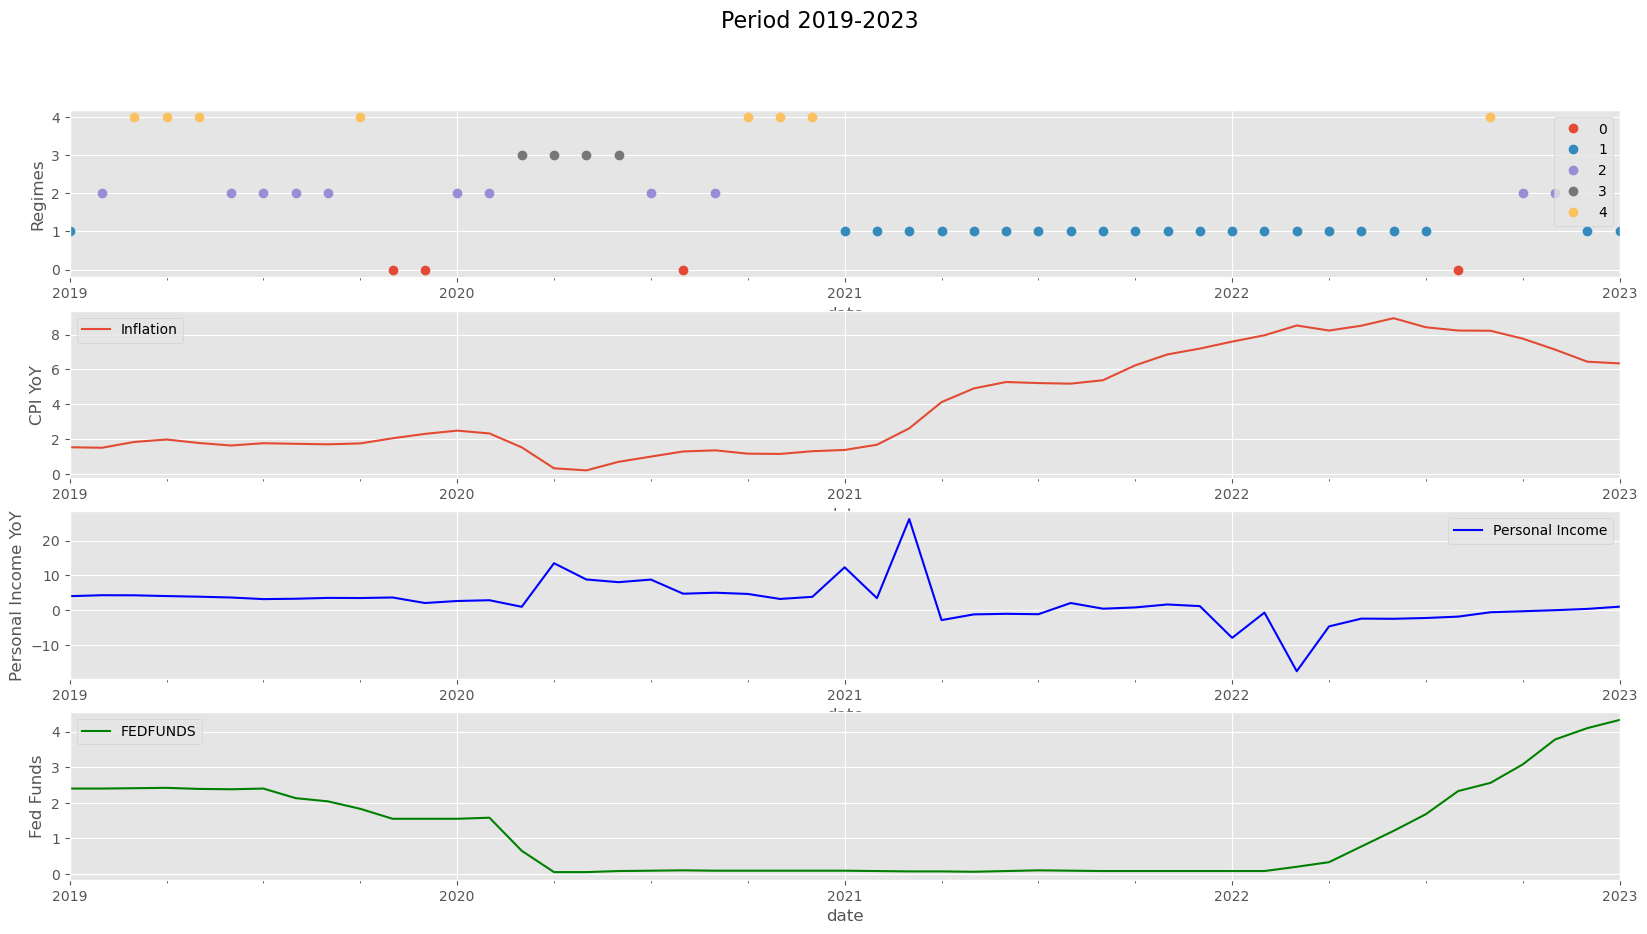

In [24]:
start = "2019-01-01"
end = "2023-01-01"

plot_df = cpi_regimes_df.copy().loc[start:end]

fig, axs = plt.subplots(4, 1, figsize=(20, 10))

fig.suptitle(f'Period {start[0:4]}-{end[0:4]}', fontsize=16)

plot_df[[v for v in range(k)]].plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Regimes")
axs[0].legend()

plot_df[["Inflation"]].plot(ax=axs[1])
axs[1].set_xlabel("date")
axs[1].set_ylabel("CPI YoY")
axs[1].legend()

plot_df[["Personal Income"]].plot(ax=axs[2])
# change color
axs[2].lines[0].set_color("blue")
axs[2].set_xlabel("date")
axs[2].set_ylabel("Personal Income YoY")
axs[2].legend()

plot_df[["FEDFUNDS"]].plot(ax=axs[3])
# change color
axs[3].lines[0].set_color("green")
axs[3].set_xlabel("date")
axs[3].set_ylabel("Fed Funds")
axs[3].legend()

In [25]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

S&P 500
variable          
0         0.175818
1         0.306056
2         0.990177
3         0.460762
4         0.828454

### Raw macro features

In [26]:
# parameters
k = 5
halflife = 3

# select data
X = macro_fred_df.ewm(halflife=halflife).mean().dropna()

In [27]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


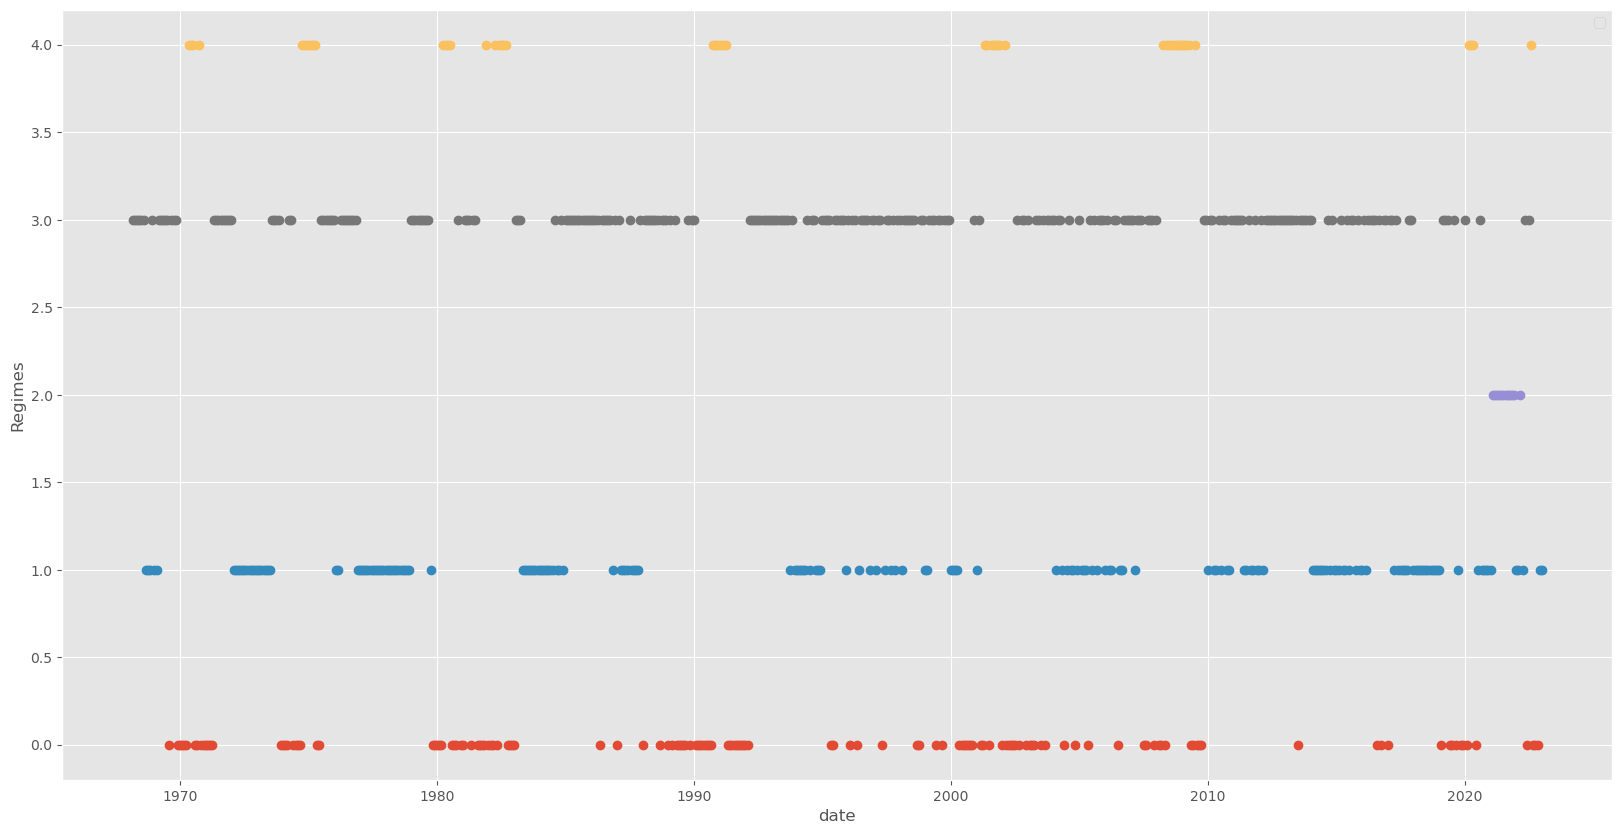

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


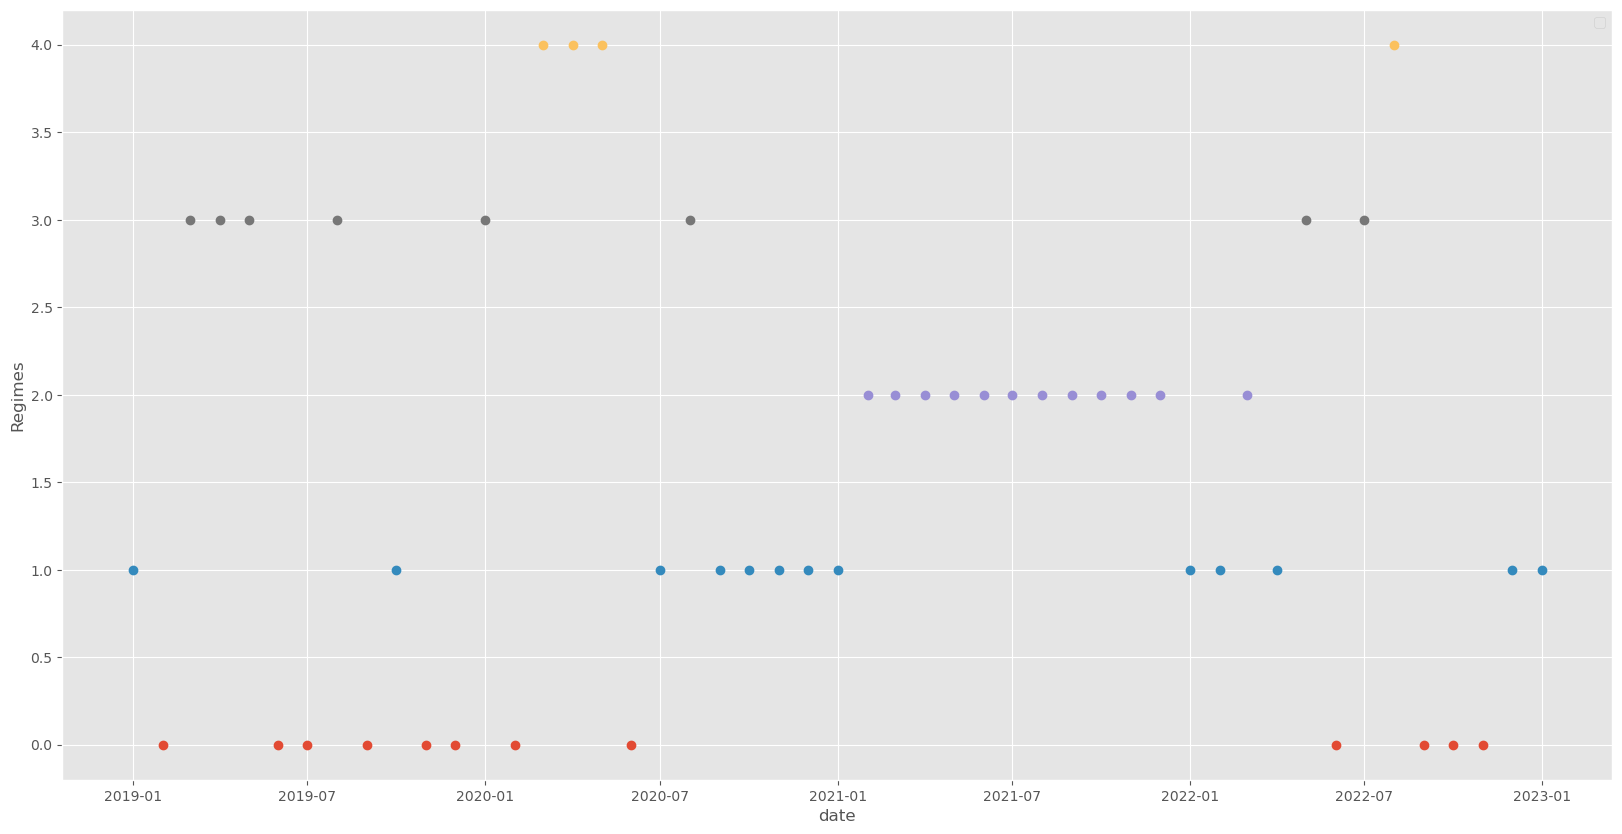

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.loc["2019-01-01":].index, pivot_X.loc["2019-01-01":].values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

### Kmeans from similarity intuition

In [30]:
# matrix (n x n)
# centroids (k x n)
# for iter=1:max_iter:
## for i=1:n:
### for j=1:n:
#### distance = d(matrix[i, j], centroid) => distance (k x n)
#### mins = argmin(distance) => mins (1 x n)
## update centroids

matrix = X_similarity
n = matrix.shape[0]

centroids = matrix[np.random.choice(n, k, replace=False)]

In [31]:
matrix[np.random.choice(n, k, replace=False)].shape

(5, 659)

In [32]:
pd.DataFrame(centroids, columns=X.index).T.tail()

0         1         2         3         4
date                                                        
2022-09-01  0.008293  0.134700  0.599747  0.053654  0.001241
2022-10-01  0.021701  0.017980  0.320515  0.000190  0.041613
2022-11-01  0.058679  0.001488  0.227386  0.010309  0.089038
2022-12-01  0.117845  0.368645  0.950695  0.229543  0.082554
2023-01-01  0.117952  0.368813  0.950930  0.229676  0.082633

In [78]:
pd.DataFrame(matrix[0,:])

0
0    0.000000
1    0.002473
2    0.001714
3    0.000299
4    0.010523
..        ...
654  0.017150
655  0.011722
656  0.041251
657  0.145850
658  0.145968

[659 rows x 1 columns]

In [33]:
pd.DataFrame(matrix[0,:] - centroids, columns=X.index).T.tail()

0         1         2         3         4
date                                                        
2022-09-01  0.008857 -0.117550 -0.582597 -0.036504  0.015909
2022-10-01 -0.009979 -0.006258 -0.308793  0.011532 -0.029891
2022-11-01 -0.017429  0.039763 -0.186136  0.030942 -0.047788
2022-12-01  0.028005 -0.222795 -0.804845 -0.083693  0.063295
2023-01-01  0.028016 -0.222844 -0.804962 -0.083708  0.063336

In [34]:
# centroids is broadcasted to match matrix[:, np.newaxis] dimension (n x 1 x n)
clusters = np.argmin(np.linalg.norm(matrix[:, np.newaxis] - centroids, axis=2), axis=1)

In [35]:
clusters

array([0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 3, 4, 0, 3, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 3, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 3, 1, 1, 3, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 4, 4, 4, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 3, 3, 3, 3, 3, 1, 4,
       3, 3, 0, 3, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 3, 0, 4, 0,
       4, 3, 0, 0, 1, 4, 3, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3,

In [36]:
n = matrix.shape[0]  # Number of points
k = centroids.shape[0]  # Number of centroids

# initialize an empty matrix to store distances
distances = np.zeros((n, k))

for i in range(n):  # loop over each month
    for j in range(k):  # loop over each cluster centroid
        # compute the Euclidean distance between the point and the centroid
        distances[i, j] = np.linalg.norm(matrix[i] - centroids[j])

In [37]:
i = 0
j = 0
print(matrix[i].shape)
print(centroids[j].shape)

(659,)
(659,)


In [38]:
matrix[i][:10]

array([0.        , 0.00247265, 0.00171421, 0.00029947, 0.01052291,
       0.02060945, 0.0349887 , 0.09946812, 0.0772247 , 0.03500429])

In [39]:
centroids[i][:10]

array([0.00172714, 0.00021699, 0.00011421, 0.00063581, 0.00403978,
       0.01086624, 0.02181531, 0.0764418 , 0.05701121, 0.02180507])

In [40]:
pd.DataFrame(distances, index=X.index).tail()

0          1          2         3         4
date                                                          
2022-09-01  1.708018   6.935101  16.400808  4.340662  0.626746
2022-10-01  2.760675   2.651561  13.077653  0.091582  3.821759
2022-11-01  4.601479   0.774212  11.411036  1.973700  5.631380
2022-12-01  6.878781  11.474829  19.083107  9.261012  5.859199
2023-01-01  6.882211  11.477797  19.084720  9.264254  5.862678